In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy.typing as npt
from datetime import date, timedelta, datetime
from dataclasses import dataclass, field
from typing import List
BASE = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids")
RLR = BASE / "rlr_monthly"

In [2]:
@dataclass
class Catalogue:
    Id: int
    Latitude: float
    Longitude: float
    name: str = field(repr=False)
    coastline: int = field(repr=False)
    stationcode: int
    flag: str = field(repr=False)

@dataclass
class RlrMonthly:
    Catalogue: Catalogue
    MinDate: np.datetime64 = field(init=False, repr=True)
    MaxDate: np.datetime64 = field(init=False, repr=True)
    Date: npt.NDArray[np.datetime64] = field(repr=False)
    Height: npt.NDArray[np.float64] = field(repr=False)
    Missing: npt.NDArray[np.int64] = field(repr=False)
    DataFlagsParse: List[str] = field(repr=False)
    IsMtl: npt.NDArray[np.bool_] = field(init=False, repr=False)
    DataFlag: npt.NDArray[np.bool_]  = field(init=False, repr=False)

    def __post_init__(self):
        IsMtl, DataFlag = [], []
        for dataFlags in self.DataFlagsParse:
            IsMtl.append(dataFlags[1] == '1')
            DataFlag.append(dataFlags[2] == '1')
        self.IsMtl = np.array(IsMtl, dtype=np.bool_)
        self.DataFlag = np.array(DataFlag, dtype=np.bool_)
        self.MinDate = min(self.Date)
        self.MaxDate = max(self.Date)

In [3]:
catalogues = []
with open(RLR / "filelist.txt", "r") as file:
    for line in file:
        values = line.replace(' ', '').replace('\n', '').split(';')
        if values[5] == 'XXX':
            continue
        catalogue = Catalogue(
            Id = int(values[0]),
            Latitude = float(values[1]),
            Longitude = float(values[2]),
            name = values[3],
            coastline = int(values[4]),
            stationcode = int(values[5]),
            flag = values[6]
        )
        catalogues.append(catalogue)

In [4]:
def decyear_to_datetime(start: float) -> datetime:
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    return base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)

In [5]:
tidegauges = []
for catalogue in catalogues:
    with open(RLR / "data" / f"{catalogue.Id}.rlrdata", "r") as file:
        obs_date, height, missings, dataflags = [], [], [], []
        heights = []
        for line in file:
            fields = line.replace(' ', '').replace('\n', '').split(';')
            obs_date.append(np.datetime64(decyear_to_datetime(float(fields[0]))))

            height = float(fields[1])
            if height == -99999:
                height = np.nan
            heights.append(height)

            missing = int(fields[2])
            if missing == -99999:
                missing = np.nan
            missings.append(missing)
            dataflags.append(fields[3])
        if not heights:
            continue
        tidegauges.append(
            RlrMonthly(
                catalogue,
                np.array(obs_date, dtype='datetime64[us]'),
                np.array(heights, dtype=np.float64),
                np.array(missings, dtype=np.int64),
                dataflags
            )
        )
tidegauges = np.array(tidegauges, dtype=object)

In [6]:
project = xr.open_dataset(BASE / "all_v4.nc")
CMEMS = xr.open_dataset(BASE / "CMEMS_all_downsampled_sla.nc")
MEASURES = xr.open_dataset(BASE / "CMEMS_all_downsampled_sla.nc")
datasets = [project, CMEMS, MEASURES]

In [7]:
max_date = np.datetime64('2019-01-01T00:00:00.000000000')
min_date = np.datetime64('1993-01-01T00:00:00.000000000')
datasets_meaned = []
for dataset in tqdm(datasets):
    project_time = dataset.time
    datset = dataset.isel(time=(project_time <= max_date) & (project_time >= min_date))
    project_time = dataset.time
    meaned_monthly_project = dataset.sla.groupby(project_time.dt.year + project_time.dt.month/12).mean(skipna=True)
    datasets_meaned.append(meaned_monthly_project)

100%|██████████| 3/3 [02:40<00:00, 53.47s/it]


In [12]:
min_dates = np.array([t.MinDate for t in tidegauges])
max_dates = np.array([t.MaxDate for t in tidegauges])

In [13]:
valid_tidegauges = tidegauges[
    (min_dates < min_date) & (max_dates > max_date)
]

In [81]:
rms_projects = []
stations = []
coefs_gauges = []
coefs_projects = []
for i, dataset in enumerate(datasets_meaned):
    coefs_project = []
    coefs_gauge = []
    rmses = []
    if i == 0:
        gauge_stations = valid_tidegauges
    else:
        gauge_stations = stations
    for gauge in tqdm(gauge_stations):
        lat_idx = np.floor(gauge.Catalogue.Latitude).astype(int) + 90
        lon_idx = np.floor(gauge.Catalogue.Longitude).astype(int) + 180
        
        gauge_month = gauge.Date.astype('datetime64[M]').astype(int) % 12 + 1
        gauge_year = gauge.Date.astype('datetime64[Y]').astype(int) + 1970
        frac_year = gauge_year + gauge_month/12


        project_time = dataset.group.values
        mask = np.isin(frac_year, project_time)

        gauge_time = frac_year[mask]
        gauge_height = (gauge.Height[mask] - 7000) / 10

        
        
        project_gauge = dataset[dataset.group.isin(frac_year), lat_idx, lon_idx]
        project_time = project_gauge.group.values
        project_sla = project_gauge.values

        if np.isnan(project_sla).all().item():
            continue
        if i == 0:
            stations.append(gauge)

        shift = np.nanmean(gauge_height - project_sla * 100)


        gh = gauge_height[~np.isnan(gauge_height)] - shift
        gt = gauge_time[~np.isnan(gauge_height)]
        coefs_gauge.append(np.linalg.lstsq(
            np.stack([np.ones(len(gt)), gt], axis=1),
            gh,
            rcond=None
        )[0])

        gh = project_sla[~np.isnan(project_sla)] * 100
        gt = project_time[~np.isnan(project_sla)]
        coefs_project.append(np.linalg.lstsq(
            np.stack([np.ones(len(gt)), gt], axis=1),
            gh,
            rcond=None
        )[0])



        shift = np.nanmean(gauge_height - project_sla * 100)
        diff_heights = gauge_height - shift - project_sla * 100
        rmses.append(np.sqrt(np.nanmean(diff_heights**2)))
    rms_projects.append(rmses)
    coefs_projects.append(coefs_project)
    coefs_gauges.append(coefs_gauge)
coefs_gauges = [np.array(c) for c in coefs_gauges]
coefs_projects = [np.array(c) for c in coefs_projects]

100%|██████████| 318/318 [00:05<00:00, 59.15it/s] 


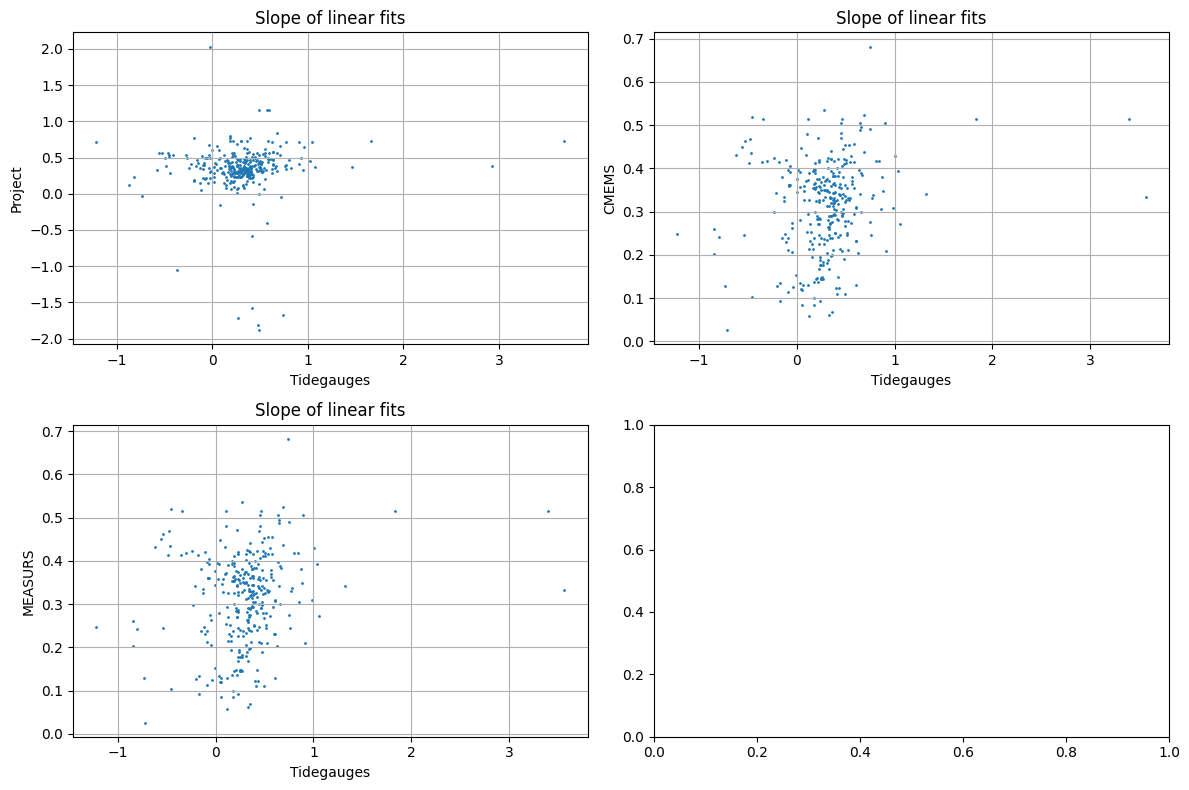

In [84]:
fig, axes = plt.subplots(2, 2, figsize=((12,8)))
axes = axes.flatten()
for idx, (ax, name) in enumerate(zip(axes, ["Project", "CMEMS", "MEASURS"])):
    ax.scatter(coefs_gauges[idx][:,1], coefs_projects[idx][:,1], s=1)
    ax.set_title(f"Slope of linear fits")
    ax.set_xlabel("Tidegauges")
    ax.set_ylabel(name)
    ax.grid()
    #ax.set_ylim([0, 0.007])
    #ax.set_ylim([-12, 0])
plt.tight_layout()
plt.show()

In [85]:
for rmses, name in zip(rms_projects, ["Project", "CMEMS", "MEASURS"]):
    print(f"{name:<10}: RMS = {np.mean(rmses):.2f} ± {np.std(rmses):.2f}cm, Median RMS = {np.median(rmses):.2f}cm")

Project   : RMS = 8.67 ± 5.69cm, Median RMS = 7.28cm
CMEMS     : RMS = 6.96 ± 3.50cm, Median RMS = 6.41cm
MEASURS   : RMS = 6.96 ± 3.50cm, Median RMS = 6.41cm


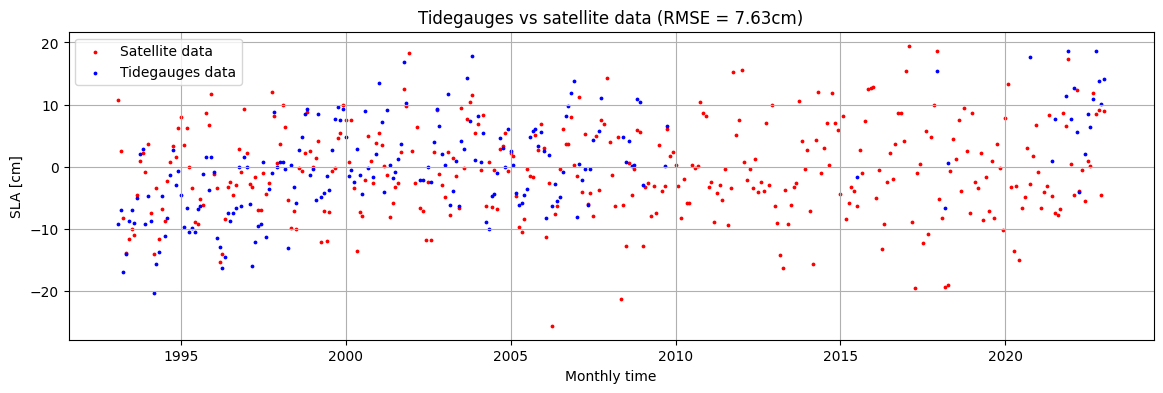

In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(project_time, project_sla * 100, s=3, color='red', label="Satellite data")
plt.scatter(gauge_time, gauge_height - shift, s=3, color='blue', label="Tidegauges data")
plt.title(f"Tidegauges vs satellite data (RMSE = {rmse:.2f}cm)")
plt.xlabel("Monthly time")
plt.ylabel("SLA [cm]")
plt.grid()
plt.legend()
plt.show()